In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import mpld3
mpld3.enable_notebook()

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [8]:
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

sys.path.append("./../../Utils/")

In [9]:
from readWikiData import get_wikipedia_data

#### Get data 

In [11]:
sentences, word2idx, idx2word, _ = get_wikipedia_data(n_files=10, n_vocab=1000, by_paragraph=True)

In [12]:
def get_wiki_data_skip_gram(sentences, word2idx, window_size=5):
    training_data = []
    vocab_size = len(word2idx)
    for sentence in sentences:
        if len(sentence) < window_size * 2 + 1:
            continue
        for i in range(len(sentence)):
            left_context = sentence[max(i-window_size, 0): i]
            right_context = sentence[i+1:window_size + i + 1]
            centre = sentence[i]
            
            if len(left_context + right_context) < (2*window_size):
                len_left = len(left_context)
                len_right = len(right_context)
                
                if len_left < len_right:
                    right_context = sentence[i+1 : window_size + i + 1 + (len_right - len_left)]
                else:
                    left_context = sentence[max(i-window_size - (len_left - len_right), 0): i]
            
            temp = left_context + right_context
            
            if len(temp) < window_size * 2:
                print sentence
                print left_context
                print right_context
                print centre
                break 
            
            training_data.append((centre, tuple(temp)))
            
            
    print training_data[:10]
    training_data = list(set(training_data))
    idx2word = {v:k for k, v in word2idx.iteritems()}
    return len(word2idx), training_data, word2idx, idx2word

In [13]:
vocab_size, training_data, word2idx, idx2word = get_wiki_data_skip_gram(sentences, word2idx)

[(1000, (8, 7, 225, 947, 12, 1000, 1000, 1000, 159, 15)), (8, (1000, 7, 225, 947, 12, 1000, 1000, 1000, 159, 15)), (7, (1000, 8, 225, 947, 12, 1000, 1000, 1000, 159, 15)), (225, (1000, 8, 7, 947, 12, 1000, 1000, 1000, 159, 15)), (947, (1000, 8, 7, 225, 12, 1000, 1000, 1000, 159, 15)), (12, (1000, 8, 7, 225, 947, 1000, 1000, 1000, 159, 15)), (1000, (8, 7, 225, 947, 12, 1000, 1000, 159, 15, 1000)), (1000, (7, 225, 947, 12, 1000, 1000, 159, 15, 1000, 1000)), (1000, (225, 947, 12, 1000, 1000, 159, 15, 1000, 1000, 55)), (159, (947, 12, 1000, 1000, 1000, 15, 1000, 1000, 55, 16))]


In [14]:
len(training_data)

11866966

In [15]:
training_data[:10]

[(6, (1000, 1000, 7, 8, 1000, 2, 1000, 1000, 3, 48)),
 (1000, (3, 2, 193, 1000, 26, 7, 707, 6, 1000, 2)),
 (32, (1000, 19, 1000, 1000, 5, 172, 615, 655, 41, 9)),
 (96, (1000, 1000, 635, 1000, 298, 45, 25, 1000, 6, 1000)),
 (11, (29, 140, 42, 58, 1000, 43, 7, 2, 1000, 502)),
 (1000, (1000, 280, 28, 2, 37, 19, 1000, 1000, 1000, 158)),
 (1000, (16, 49, 402, 178, 1000, 2, 244, 1000, 362, 1000)),
 (116, (10, 1000, 20, 127, 1000, 471, 506, 4, 20, 1000)),
 (58, (449, 1000, 977, 1000, 42, 683, 4, 7, 525, 1000)),
 (4, (1000, 5, 56, 1000, 1000, 1000, 1000, 1000, 761, 1000))]

##### Get batches

In [16]:
bucket_list = []

def getNextBatchSkipGram(bi_grams_, window_size=5, batch_size=10000):
    global bucket_list
    docs_ids_to_select = list(set(bi_grams_) - set(bucket_list))
    
    if len(docs_ids_to_select) < batch_size:
        bucket_list = []
        docs_ids_to_select = bi_grams_
        
    # Initialize two variables 
    train_X = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    train_label = np.ndarray(shape=(batch_size, window_size*2), dtype=np.int32)
    
    # Get a random set of docs 
    random_docs = random.sample(docs_ids_to_select, batch_size)
    bucket_list += random_docs
    
    
    index = 0 
    
    # Iterate threw all the docs 
    for item in random_docs:
        train_X[index] = item[0]
        train_label[index] = item[1]  
        index += 1
            
    return train_X, train_label

In [17]:
getNextBatchSkipGram(training_data)

(array([[ 412],
        [ 198],
        [1000],
        ..., 
        [  48],
        [1000],
        [  17]], dtype=int32),
 array([[  25,  181, 1000, ...,  462,   12,    2],
        [   4,  186,  510, ...,   96,   45, 1000],
        [   3,    2,  493, ...,    2, 1000, 1000],
        ..., 
        [  37,  537, 1000, ..., 1000,    8,   15],
        [   7, 1000, 1000, ...,   43, 1000,   67],
        [  13,    2, 1000, ..., 1000,   24, 1000]], dtype=int32))

##### Let's design the graph for skip gram model 

In [18]:
def init_weight(Mi, Mo):
    shape_sum = float(Mi + Mo) 
    return np.random.uniform(-np.sqrt(6/shape_sum),np.sqrt(6/shape_sum), [Mi, Mo])

In [19]:
embedding_size_w = 100
vocab_size = len(word2idx)
n_neg_samples = 20
learning_rate = 10e-5
epochs = 2
batch_size=10000
mu = 0.99
window_size = 5

In [20]:
# Define placeholders for training 
train_X = tf.placeholder(tf.int32, shape=[batch_size, 1])
train_label = tf.placeholder(tf.int32, shape=[batch_size, None])

In [21]:
# Define matrix for doc_embedding and word_embedding 
W1 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W1", dtype=tf.float32)

In [22]:
# Define weights for the output unit 
W2 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W2", dtype=tf.float32)
biases = tf.Variable(tf.zeros(vocab_size))

In [23]:
print(train_X.get_shape(), train_label.get_shape(), W1.get_shape(), W2.get_shape())

(TensorShape([Dimension(10000), Dimension(1)]), TensorShape([Dimension(10000), Dimension(None)]), TensorShape([Dimension(1001), Dimension(100)]), TensorShape([Dimension(1001), Dimension(100)]))


In [24]:
embed = tf.nn.embedding_lookup(W1, train_X[0])

In [25]:
loss = tf.nn.sampled_softmax_loss(weights=W2, \
                                  biases=biases, \
                                  labels=train_label, \
                                  inputs=embed, \
                                  num_sampled=n_neg_samples, \
                                  num_classes=vocab_size, 
                                  num_true=window_size*2)

In [26]:
loss = tf.reduce_mean(loss)

In [27]:
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=mu).minimize(loss)
#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 10e-5
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
optimizer = (
    tf.train.MomentumOptimizer(learning_rate, momentum=mu).minimize(loss, global_step=global_step)
)


In [29]:
saver = tf.train.Saver()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    average_loss = 0
    
    for step in range(epochs):
        epoch_error = 0.0
        temp_X , temp_labels = getNextBatchSkipGram(window_size=5, bi_grams_=training_data)
        
        feed_dict = {train_X : temp_X, train_label : temp_labels}
        
        op, l = sess.run([optimizer, loss], 
                                    feed_dict=feed_dict)
        
        epoch_error += l
                
        if step % 100 == 0:
            print "Error at epoch : ", step, " = ", epoch_error
            
    save_path = saver.save(sess, "./models/model_skipgram_model.ckpt")
    print("Model saved in file: %s" % save_path)

Error at epoch :  0  =  3.97917890549
Model saved in file: ./models/model_skipgram_model.ckpt


##### Embeddings 

In [31]:
W1_embedding = None
W2_embedding = None 

with tf.Session() as sess:
    saver = tf.train.Saver()
    # Restore variables from disk.
    saver.restore(sess, "./models/model_skipgram_model.ckpt")
    print("Model restored.")
    
    # Normalize word2vec 
    W1_embedding = W1.eval()
    
    # Normalize word2vec 
    W2_embedding = W2.eval()

Model restored.


In [32]:
word2vec = np.mean([W1_embedding, W2_embedding], axis=0)

##### Projection of embeddings using t-SNE 

In [33]:
idx2word = {v:k for k, v in word2idx.items()}

In [34]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

bad string: –


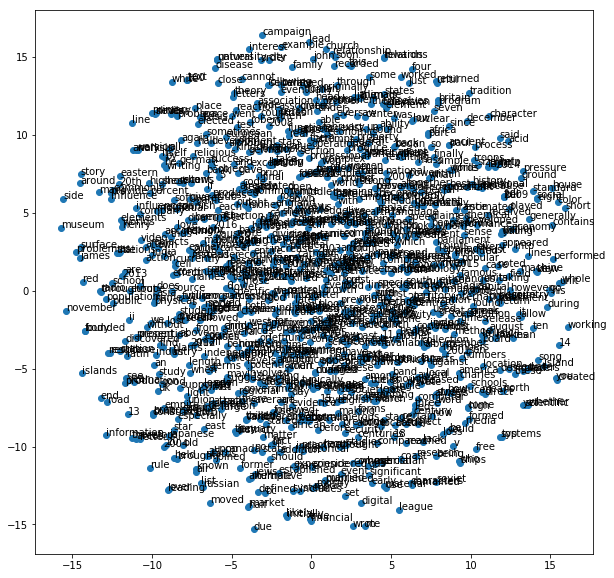

In [35]:
plt.scatter(Z[:,0], Z[:,1])
for i in xrange(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print "bad string:", idx2word[i]
plt.show()